# KNN Classifier

KNN is sensitive to differences in scale between features, so it is a good idea to scale the data before using this algorithm.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from ucimlrepo import fetch_ucirepo
data_iris = fetch_ucirepo(id=53)
data_wine = fetch_ucirepo(id=109)
data_glass = fetch_ucirepo(id=42)

def to_pd(data):
    df = pd.DataFrame(data.data.features, columns=data.data.feature_names)
    df['class'] = data.data.targets
    return df

df_iris = to_pd(data_iris)
df_wine = to_pd(data_wine)
df_glass = to_pd(data_glass)

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier

def knn_classifier(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    knn = KNeighborsClassifier()
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    return y_test, y_pred

In [4]:
from sklearn.metrics import confusion_matrix, f1_score

def knn_report(data, target):
    X = data.drop(target, axis=1)
    y = data[target]
    y_test, y_pred = knn_classifier(X, y)
    
    return confusion_matrix(y_test, y_pred), f1_score(y_test, y_pred, average='weighted')

In [5]:
iris_report = knn_report(df_iris, 'class')
wine_report = knn_report(df_wine, 'class')
glass_report = knn_report(df_glass, 'class')

In [6]:
def addlabels(fig, x,y):
    for i in range(len(x)):
        fig.text(i, y[i]/2, round(y[i], 4), ha = 'center')

Text(0.5, 1.0, 'F1 Score')

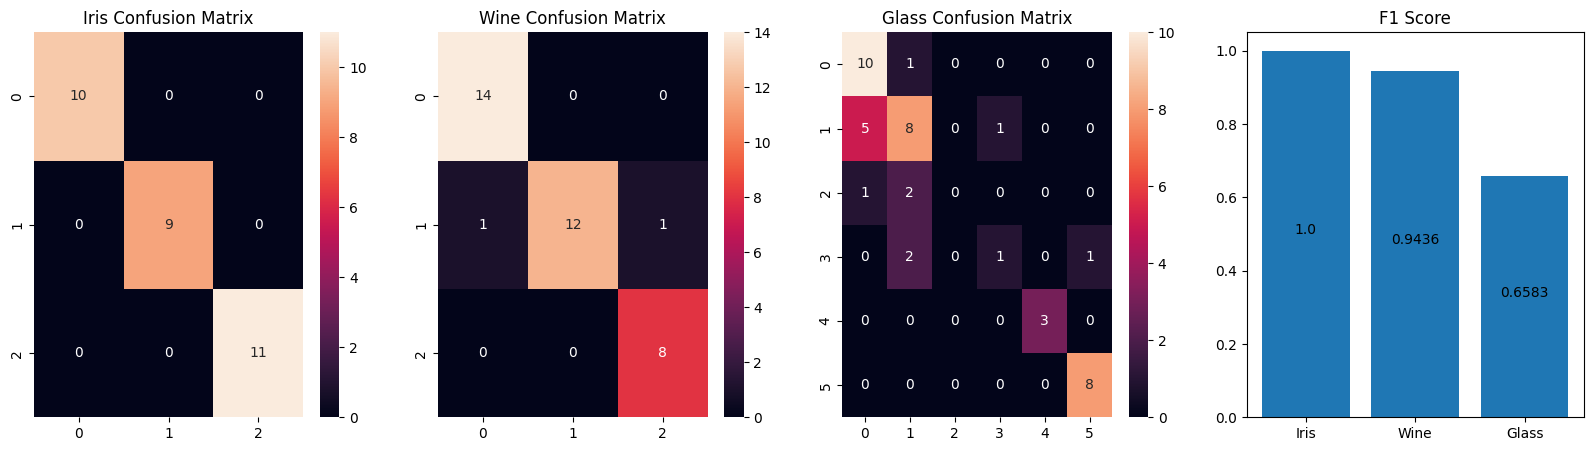

In [7]:
fig, axs = plt.subplots(1, 4, figsize=(20, 5))

sns.heatmap(iris_report[0], annot=True, ax=axs[0])
axs[0].set_title('Iris Confusion Matrix')

sns.heatmap(wine_report[0], annot=True, ax=axs[1])
axs[1].set_title('Wine Confusion Matrix')

sns.heatmap(glass_report[0], annot=True, ax=axs[2])
axs[2].set_title('Glass Confusion Matrix')

axs[3].bar(['Iris', 'Wine', 'Glass'], [iris_report[1], wine_report[1], glass_report[1]])
addlabels(axs[3], ['Iris', 'Wine', 'Glass'], [iris_report[1], wine_report[1], glass_report[1]])
axs[3].set_title('F1 Score')

# Cross Validation

In [8]:
from sklearn.model_selection import KFold

def knn_cross_val(data, target, fold=5):
    cv = KFold(n_splits=fold, shuffle=True, random_state=42)
    X = data.drop(target, axis=1)
    y = data[target]
    scores = []
    for train_index, test_index in cv.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
        knn = KNeighborsClassifier()
        knn.fit(X_train, y_train)
        y_pred = knn.predict(X_test)
        scores.append(f1_score(y_test, y_pred, average='weighted'))
        
    return np.mean(scores)


In [9]:
folds = [2, 3, 4, 5, 6, 7, 8, 9, 10]

iris_scores = [knn_cross_val(df_iris, 'class', fold) for fold in folds]
wine_scores = [knn_cross_val(df_wine, 'class', fold) for fold in folds]
glass_scores = [knn_cross_val(df_glass, 'class', fold) for fold in folds]

In [10]:
from sklearn.model_selection import StratifiedKFold

def knn_cross_val_stratified(data, target, fold=5):
    X = data.drop(target, axis=1)
    y = data[target]
    cv = StratifiedKFold(n_splits=fold, shuffle=True, random_state=42)
    
    scores = []
    for train_index, test_index in cv.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
        knn = KNeighborsClassifier()
        knn.fit(X_train, y_train)
        y_pred = knn.predict(X_test)
        scores.append(f1_score(y_test, y_pred, average='weighted'))
        
    return np.mean(scores)

In [11]:
folds_s = [2, 3, 4, 5, 6, 7, 8, 9]  # since glass has 9 classes

iris_scores_s = [knn_cross_val_stratified(df_iris, 'class', fold) for fold in folds_s]
wine_scores_s = [knn_cross_val_stratified(df_wine, 'class', fold) for fold in folds_s]
glass_scores_s = [knn_cross_val_stratified(df_glass, 'class', fold) for fold in folds_s]
# 
# iris_scores_s.append(0)
# wine_scores_s.append(0)
# glass_scores_s.append(0)

Text(0.5, 1.0, 'Stratified Cross Validation vs Cross Validation')

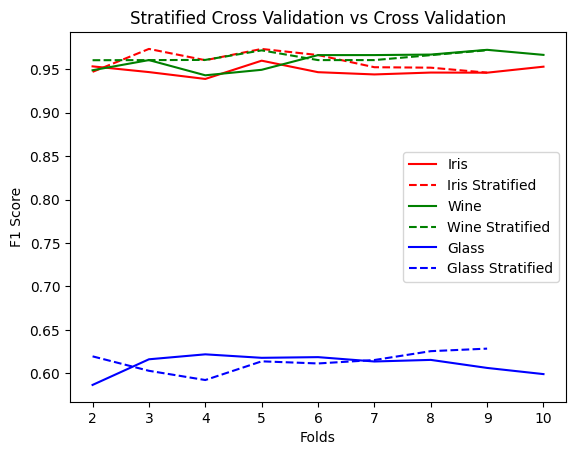

In [12]:

sns.lineplot(x=folds, y=iris_scores, label='Iris', color='red')
sns.lineplot(x=folds_s, y=iris_scores_s, label='Iris Stratified', linestyle='--', color='red')

sns.lineplot(x=folds, y=wine_scores, label='Wine', color='green')
sns.lineplot(x=folds_s, y=wine_scores_s, label='Wine Stratified', linestyle='--', color='green')

sns.lineplot(x=folds, y=glass_scores, label='Glass', color='blue')
sns.lineplot(x=folds_s, y=glass_scores_s, label='Glass Stratified', linestyle='--', color='blue')

plt.xlabel('Folds')
plt.ylabel('F1 Score')
plt.title('Stratified Cross Validation vs Cross Validation')

# Conclusion

#### Should we shuffle the data?

It varys from case to case. In case of time series data, we should not shuffle the data. In case of other data, we can shuffle the data.
We can use data shuffling to avoid the impact of data distribution on validation results

#### Validation leave-one-out?

Leave-one-out is a good validation method when we have a small dataset. But it is computationally expensive. It is not recommended for large datasets.

#### Stratified K-Fold?

Stratify provides us that each fold has the same proportion of classes. It is generally a good idea to use stratified k-fold cross-validation to maintain the distribution of classes in each fold. 

We can benefit from stratified k-fold cross-validation when we have **imbalanced datasets**.

<br>

In cross validation we calculate the average of the results of the folds because we want to see the generalization performance of the model.

# How k affects the model

In [13]:
def knn_k_effect(data, target, k):
    X = data.drop(target, axis=1)
    y = data[target]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    return f1_score(y_test, y_pred, average='weighted')

In [14]:
ks = range(1, 16)

iris_scores = [knn_k_effect(df_iris, 'class', k) for k in ks]
wine_scores = [knn_k_effect(df_wine, 'class', k) for k in ks]
glass_scores = [knn_k_effect(df_glass, 'class', k) for k in ks]

Text(0.5, 1.0, 'KNN K Effect')

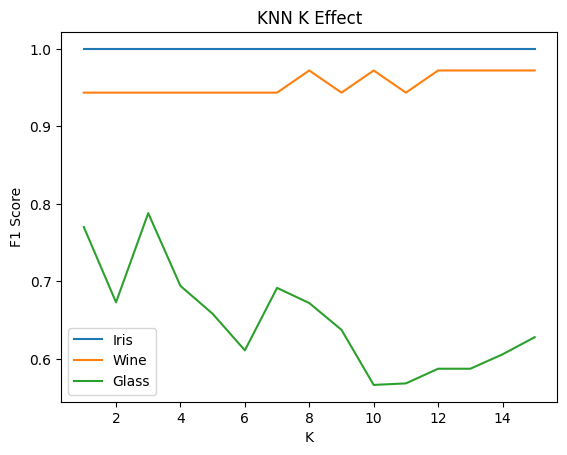

In [15]:
sns.lineplot(x=ks, y=iris_scores, label='Iris')
sns.lineplot(x=ks, y=wine_scores, label='Wine')
sns.lineplot(x=ks, y=glass_scores, label='Glass')
plt.xlabel('K')
plt.ylabel('F1 Score')
plt.title('KNN K Effect')

# Conclusion

We can see that for data set in even number of classes, the best is to use odd number of k. For data set with odd number of classes, the best is to use even number of k.

But it is not always the case. 
Most of the time, the best k is odd number, because it not produce ties.

Glass -> Number of classes: 6 -> Best k = 3
Wine -> Number of classes: 3 -> Best k = 8/10, 12 to 15
Iris -> Number of classes: 3 -> All because it is simple data set

# How weights affect the model

In [16]:
def knn_weights_effect(data, target, weight):
    X = data.drop(target, axis=1)
    y = data[target]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    knn = KNeighborsClassifier(weights=weight)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    return f1_score(y_test, y_pred, average='weighted')

In [17]:
def inverse_distance_square_weights(distances):
     with np.errstate(divide='ignore', invalid='ignore'):
        return 1.0 / np.square(distances)
     
def gaussian_weights(distances):
    sigma = 1
    return np.exp(-0.5 * (distances / sigma) ** 2)


In [18]:
weights = ['uniform', 'distance', inverse_distance_square_weights, gaussian_weights]

iris_scores = [knn_weights_effect(df_iris, 'class', weight) for weight in weights]
wine_scores = [knn_weights_effect(df_wine, 'class', weight) for weight in weights]
glass_scores = [knn_weights_effect(df_glass, 'class', weight) for weight in weights]

Text(0.5, 1.0, 'Glass F1 Score')

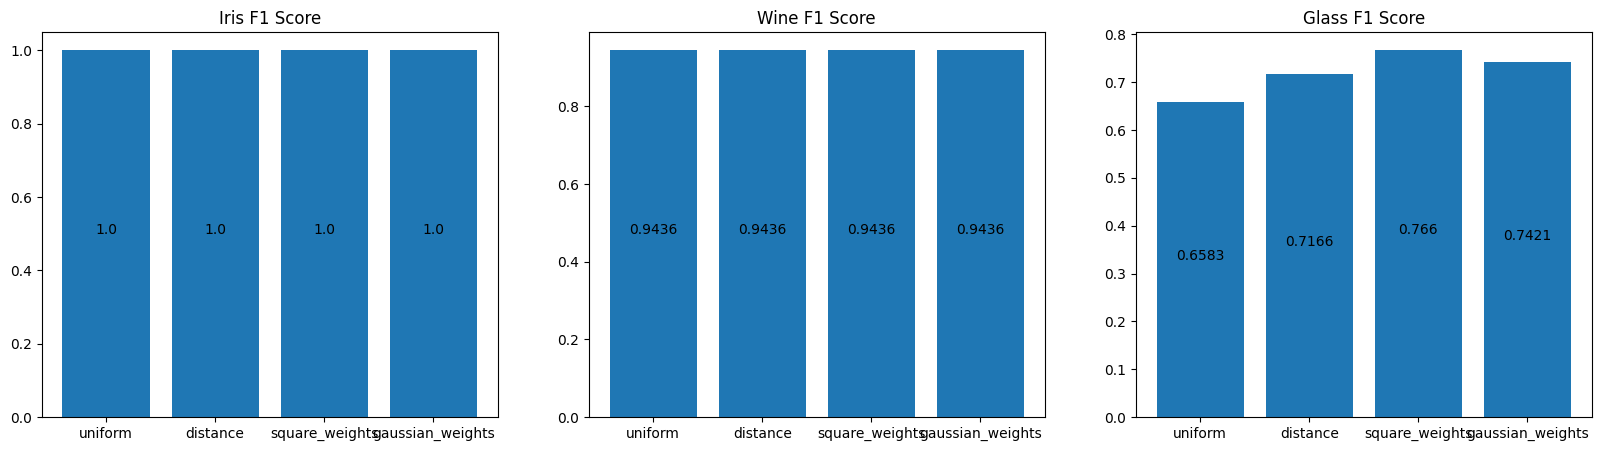

In [19]:
weights = ['uniform', 'distance', 'square_weights', 'gaussian_weights']

fig, axs = plt.subplots(1, 3, figsize=(20, 5))

axs[0].bar(weights, iris_scores)
addlabels(axs[0], weights, iris_scores)
axs[0].set_title('Iris F1 Score')

axs[1].bar(weights, wine_scores)
addlabels(axs[1], weights, wine_scores)
axs[1].set_title('Wine F1 Score')

axs[2].bar(weights, glass_scores)
addlabels(axs[2], weights, glass_scores)
axs[2].set_title('Glass F1 Score')


Proposed weights functions by me:
- inverse_distance_square_weights
    - it is similar to distance, but it is more sensitive to the distance since it is squared
- gaussian_weights
    - it is similar to distance but ensures smoother transition between the weights

# Impact of the distance metric

In [20]:
def knn_metric_effect(data, target, metric, metrics_params=None, p=2):
    X = data.drop(target, axis=1)
    y = data[target]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    knn = KNeighborsClassifier(metric=metric, metric_params=metrics_params, p=p)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    return f1_score(y_test, y_pred, average='weighted')

In [21]:
metrics = [
    {'metric': 'euclidean'},
    {'metric': 'manhattan'},
    {'metric': 'chebyshev'},
    {'metric': 'minkowski', 'p': 3},
    # {'metric': 'mahalanobis', 'metrics_params': {'V': np.cov(df_iris.drop('class', axis=1).T)}}
]

iris_scores = [knn_metric_effect(df_iris, 'class', **metric) for metric in metrics]
wine_scores = [knn_metric_effect(df_wine, 'class', **metric) for metric in metrics]
glass_scores = [knn_metric_effect(df_glass, 'class', **metric) for metric in metrics]

iris_scores.append(knn_metric_effect(df_iris, 'class', 'mahalanobis', {'V': np.cov(df_iris.drop('class', axis=1).T)}))
wine_scores.append(knn_metric_effect(df_wine, 'class', 'mahalanobis', {'V': np.cov(df_wine.drop('class', axis=1).T)}))
glass_scores.append(knn_metric_effect(df_glass, 'class', 'mahalanobis', {'V': np.cov(df_glass.drop('class', axis=1).T)}))

Text(0.5, 1.0, 'Glass F1 Score')

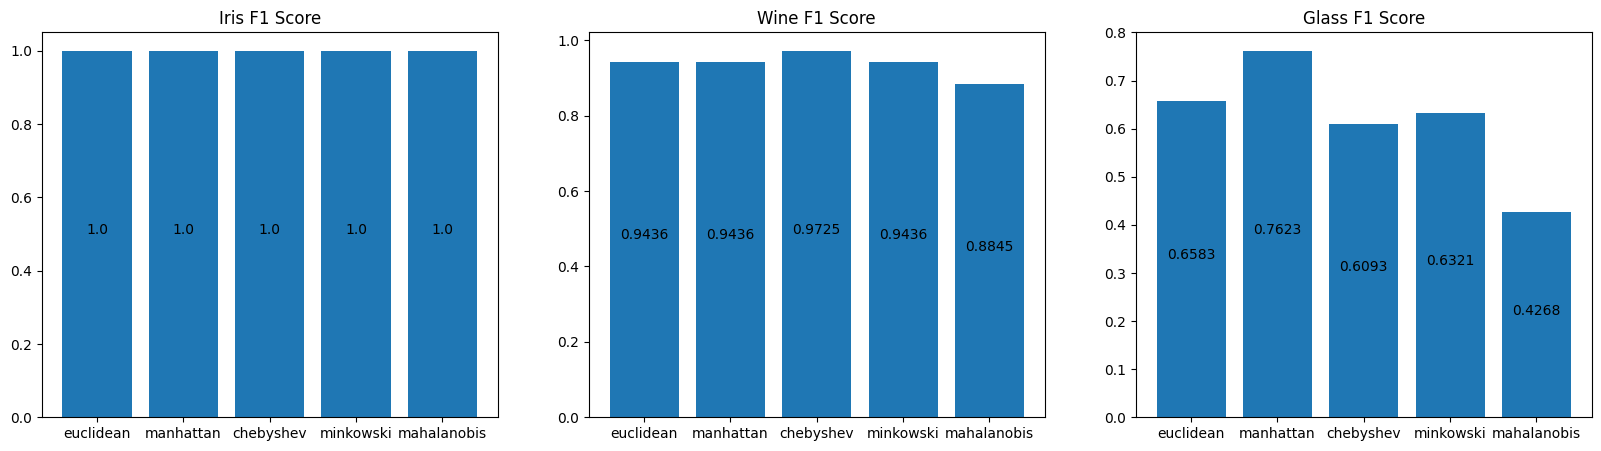

In [22]:
distances_names = ['euclidean', 'manhattan', 'chebyshev', 'minkowski', 'mahalanobis']

fig, axs = plt.subplots(1, 3, figsize=(20, 5))

axs[0].bar(distances_names, iris_scores)
addlabels(axs[0], distances_names, iris_scores)
axs[0].set_title('Iris F1 Score')

axs[1].bar(distances_names, wine_scores)
addlabels(axs[1], distances_names, wine_scores)
axs[1].set_title('Wine F1 Score')

axs[2].bar(distances_names, glass_scores)
addlabels(axs[2], distances_names, glass_scores)
axs[2].set_title('Glass F1 Score')


# Conclusion

Minowski distance is a generalization of Euclidean and Manhattan distances. It is a good idea to use Minowski distance when we are not sure which distance metric to use.
p=1 -> Manhattan
p=2 -> Euclidean
p_n -> minowski l_n distance

The best distance metric for:
- Wine is chebyshev
- Glass is manhattan

# Grid Search

We can now search for the best hyperparameters for the model using Grid Search.

In [23]:
from sklearn.model_selection import GridSearchCV

def knn_grid_search(data, target):
    X = data.drop(target, axis=1)
    y = data[target]
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    knn = KNeighborsClassifier()
    params = {
        'n_neighbors': range(1, 16),
        'weights': ['uniform', 'distance', inverse_distance_square_weights, gaussian_weights],
        'metric': ['euclidean', 'manhattan', 'chebyshev', 'minkowski'],
        'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
    }
    grid = GridSearchCV(knn, params, cv=cv, scoring='f1_weighted')
    grid.fit(X, y)
    return grid.best_params_, grid.best_score_

In [24]:
iris_best_params, iris_best_score = knn_grid_search(df_iris, 'class')
print('Iris best params:', iris_best_params)
print('Iris best score:', iris_best_score)

Iris best params: {'algorithm': 'auto', 'metric': 'euclidean', 'n_neighbors': 6, 'weights': 'uniform'}
Iris best score: 0.9732664995822891


In [25]:
wine_best_params, wine_best_score = knn_grid_search(df_wine, 'class')
print('Wine best params:', wine_best_params)
print('Wine best score:', wine_best_score)

Wine best params: {'algorithm': 'auto', 'metric': 'manhattan', 'n_neighbors': 11, 'weights': <function inverse_distance_square_weights at 0x0000020F89BAA840>}
Wine best score: 0.9829991045991047


In [26]:
glass_params, glass_score = knn_grid_search(df_glass, 'class')
print('Glass best params:', glass_params)
print('Glass best score:', glass_score)

Glass best params: {'algorithm': 'auto', 'metric': 'manhattan', 'n_neighbors': 3, 'weights': <function inverse_distance_square_weights at 0x0000020F89BAA840>}
Glass best score: 0.7430542089368988
